In [19]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Download data from Yahoo Finance
start_date = "2010-01-01"
end_date = "2023-12-31"
data = yf.download("CL=F", start=start_date, end=end_date)


[*********************100%***********************]  1 of 1 completed


In [2]:
data = yf.download("CL=F", start=start_date, end=end_date)
data

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,CL=F,CL=F,CL=F,CL=F,CL=F,CL=F
Date,,,,,,
2010-01-04,81.510002,81.510002,81.680000,79.629997,79.629997,263542
2010-01-05,81.769997,81.769997,82.000000,80.949997,81.629997,258887
2010-01-06,83.180000,83.180000,83.519997,80.849998,81.430000,370059
2010-01-07,82.660004,82.660004,83.360001,82.260002,83.199997,246632
2010-01-08,82.750000,82.750000,83.470001,81.800003,82.650002,310377
...,...,...,...,...,...,...
2023-12-22,73.559998,73.559998,74.980003,73.389999,73.910004,222600
2023-12-26,75.570000,75.570000,76.180000,73.129997,73.559998,208715


In [3]:
data = data.reset_index()
data = data[['Date', ('Adj Close')]]


In [4]:
import datetime

def str_to_datetime(s):
    if isinstance(s, datetime.datetime):
        return s
    else:
        s = str(s)
        split = s.split('-')
        year, month, day = int(split[0]), int(split[1]), int(split[2])
        return datetime.datetime(year=year, month=month, day=day)


datetime_object = str_to_datetime('2001-01-02')
datetime_object


datetime.datetime(2001, 1, 2, 0, 0)

In [5]:
data['Date'] = data['Date'].apply(str_to_datetime)
data['Date']


,Date
0,2010-01-04
1,2010-01-05
2,2010-01-06
3,2010-01-07
4,2010-01-08
...,...
3515,2023-12-22
3516,2023-12-26
3517,2023-12-27
3518,2023-12-28


In [6]:
data.index = data.pop('Date')
print("CrudeOil\n",data)
print("CrudeOil\n",data.shape)

CrudeOil
 Price       Adj Close
Ticker           CL=F
Date                 
2010-01-04  81.510002
2010-01-05  81.769997
2010-01-06  83.180000
2010-01-07  82.660004
2010-01-08  82.750000
...               ...
2023-12-22  73.559998
2023-12-26  75.570000
2023-12-27  74.110001
2023-12-28  71.769997
2023-12-29  71.650002

[3520 rows x 1 columns]
CrudeOil
 (3520, 1)


In [7]:
data_null = data.copy()
null_indices = np.random.choice(data_null.index, size=int(len(data_null) * 0.1), replace=False)
data_null.loc[null_indices, "Adj Close"] = np.nan

# Fill null values (method: fill with mean)
data_filled_mean = data_null.fillna(data_null.mean())


In [8]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(np.array(data_filled_mean).reshape(-1,1))


In [9]:
train = int(len(data_filled_mean)*0.7)
test = len(data_filled_mean) - train

train_data, test_data = scaled_data[0:train,:],scaled_data[train:len(scaled_data),:1]
# train_data, test_data = train_test_split(data_filled_mean, test_size=0.3, random_state=42, shuffle=True)
test_data[124] = np.mean(test_data)

In [10]:
train_data

array([[0.73848636],
       [0.74009793],
       [0.7488378 ],
       ...,
       [0.56399927],
       [0.5675324 ],
       [0.56660262]])

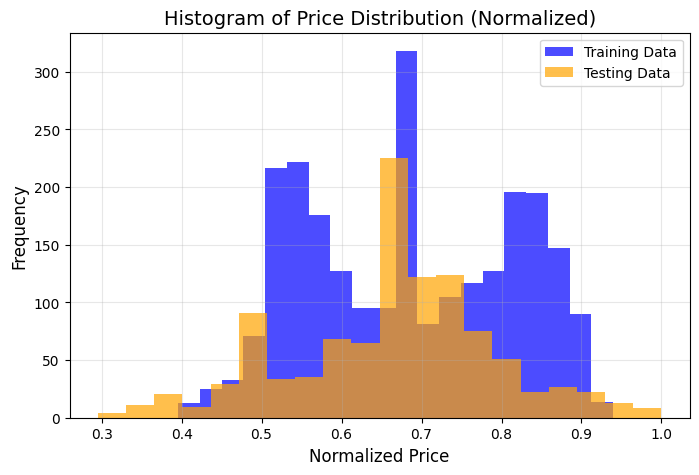

In [11]:
plt.figure(figsize=(8, 5))
plt.hist(train_data, bins=20, color='blue', alpha=0.7, label='Training Data')
plt.hist(test_data, bins=20, color='orange', alpha=0.7, label='Testing Data')
plt.title("Histogram of Price Distribution (Normalized)", fontsize=14)
plt.xlabel("Normalized Price", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd

# تنظیمات مدل‌ها
learning_rate = 0.0010  # Learning rate updated to 0.0010
batch_size = 100
epochs = 50
units_lstm_gru = 512
units_bilstm = 1024

# تعریف تابع برای ساخت مدل‌ها
def create_model(model_type, input_shape):
    model = Sequential()
    if model_type == "LSTM":
        model.add(LSTM(units_lstm_gru, input_shape=input_shape))
    elif model_type == "GRU":
        model.add(GRU(units_lstm_gru, input_shape=input_shape))
    elif model_type == "Bi-LSTM":
        model.add(Bidirectional(LSTM(units_bilstm), input_shape=input_shape))
    model.add(Dense(1))  # خروجی نهایی
    model.compile(optimizer=Adam(learning_rate), loss='mse')
    return model

def create_dataset(crudeoil_df, time_step=365):
    # Ensure the data is a NumPy array
    crudeoil_df = crudeoil_df.values if isinstance(crudeoil_df, pd.DataFrame) else np.array(crudeoil_df)

    C_dataX, C_dataY = [], []
    for i in range(len(crudeoil_df) - time_step):
        a = crudeoil_df[i:(i + time_step)]
        aa = np.round(a, 5)
        C_dataX.append(aa)
        C_dataY.append(crudeoil_df[i + time_step])
    return np.array(C_dataX, dtype=np.float16), np.array(C_dataY, dtype=np.float16)


# شکل ورودی داده‌ها
input_shape = (train_data.shape[1], 1)  # داده‌های نرمال‌شده به فرمت سری زمانی

# آماده‌سازی داده‌ها برای ورودی مدل
X_train, y_train = create_dataset(train_data, time_step=10)
X_test, y_test = create_dataset(test_data, time_step=10)

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

X_train = np.asarray(X_train).astype(np.float16)
y_train = np.asarray(y_train).astype(np.float16)
X_test = np.asarray(X_test).astype(np.float16)
y_test = np.asarray(y_test).astype(np.float16)


In [13]:
X_train.shape

(2454, 10, 1)

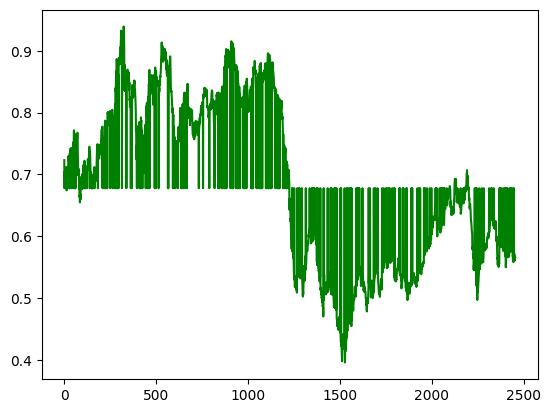

In [14]:

plt.plot(y_train.flatten(), label='Train Values', color='green')
plt.show()

In [ ]:
# ساخت و آموزش مدل‌ها
models = {}
for model_type in ["LSTM", "GRU", "Bi-LSTM"]:
    print(f"Training {model_type}...")
    model = create_model(model_type, input_shape)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
    models[model_type] = model


Training LSTM...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - loss: 0.1015
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - loss: 0.0036
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 0.0028
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 0.0024
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.0027
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0024
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 0.0023
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0023
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 0.0023
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0025
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 0.0026
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 0.0023
Epoch 13/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 0.0025
Epoch 14/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 0.0023
Epoch 15/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - lo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 17s 719ms/step - loss: 0.1045
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 723ms/step - loss: 0.0067
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 728ms/step - loss: 0.0046
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 727ms/step - loss: 0.0037
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 724ms/step - loss: 0.0032
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 727ms/step - loss: 0.0036
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 732ms/step - loss: 0.0031
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 719ms/step - loss: 0.0029
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 727ms/step - loss: 0.0027
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 723ms/step - loss: 0.0029
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 730ms/step - loss: 0.0024
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 727ms/step - loss: 0.0051
Epoch 13/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 721ms/step - loss: 0.0033
Epoch 14/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 725ms/step - loss: 0.0025
Epoch 15/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
LSTM MSE: 0.0019321148283779621

LSTM - Real vs Predicted Values:
    Real Values  Predicted Values
0     0.596680          0.590369
1     0.601074          0.589028
2     0.603516          0.587569
3     0.602539          0.586531
4     0.601074          0.585758


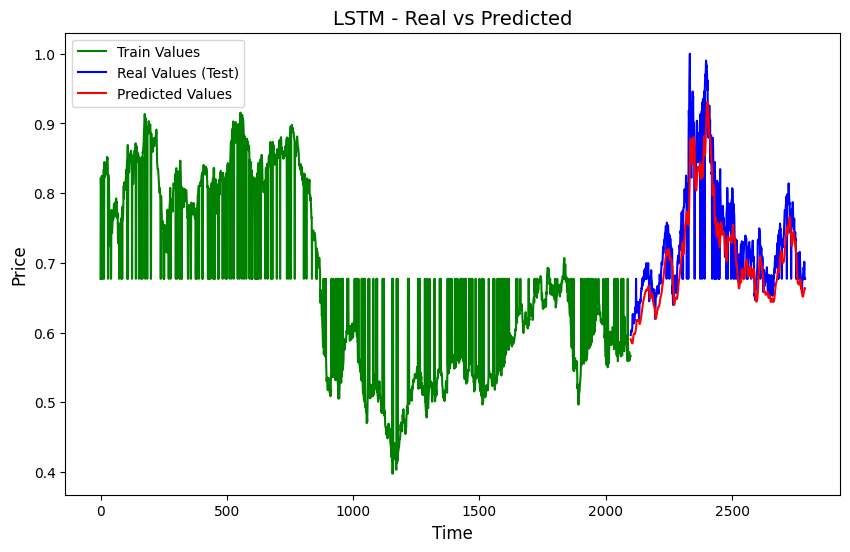

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
GRU MSE: 0.0012924561742693186

GRU - Real vs Predicted Values:
    Real Values  Predicted Values
0     0.596680          0.615717
1     0.601074          0.613569
2     0.603516          0.612211
3     0.602539          0.611415
4     0.601074          0.610658


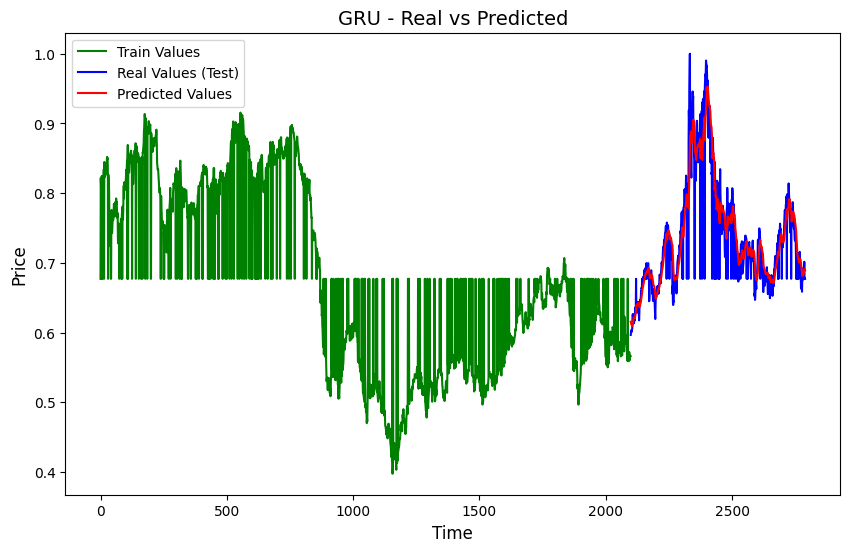

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step
Bi-LSTM MSE: 0.0015146237565204501

Bi-LSTM - Real vs Predicted Values:
    Real Values  Predicted Values
0     0.596680          0.625957
1     0.601074          0.624666
2     0.603516          0.623251
3     0.602539          0.622321
4     0.601074          0.621364


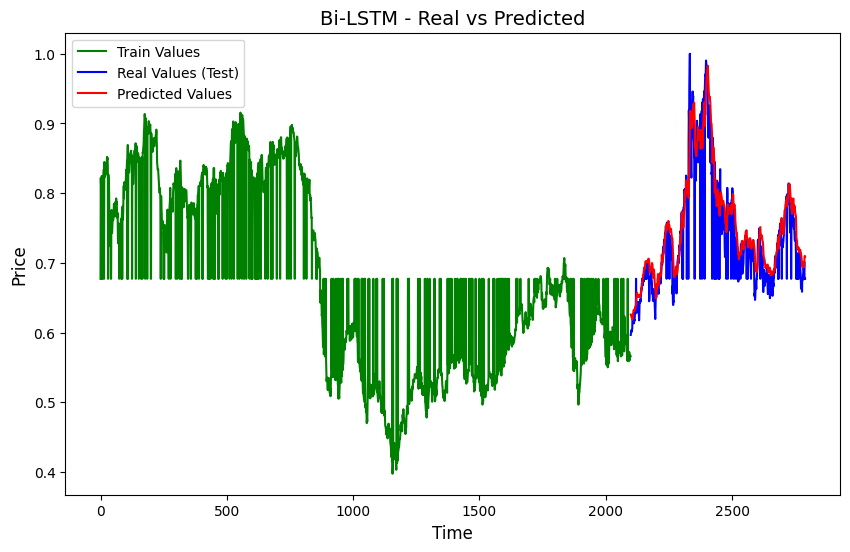


Model Performance:
LSTM: MSE = 0.0019321148283779621
GRU: MSE = 0.0012924561742693186
Bi-LSTM: MSE = 0.0015146237565204501


In [ ]:
# ارزیابی مدل‌ها و نمایش نتایج
results = {}
for model_type, model in models.items():
    # پیش‌بینی داده‌های آزمایشی
    y_pred = model.predict(X_test)

    # محاسبه MSE
    mse = mean_squared_error(y_test, y_pred)
    results[model_type] = mse
    print(f"{model_type} MSE: {mse}")

    # نمایش مقایسه پیش‌بینی‌ها و مقادیر واقعی
    comparison_df = pd.DataFrame({
        'Real Values': y_test.flatten(),
        'Predicted Values': y_pred.flatten()
    })

    print(f"\n{model_type} - Real vs Predicted Values:\n", comparison_df.head())

    # Extend the x-axis for y_test and y_pred
    extended_y_real = np.concatenate([y_train.flatten(), y_test.flatten()])
    extended_y_pred = np.concatenate([np.full(len(y_train), np.nan), y_pred.flatten()])

    plt.figure(figsize=(10, 6))
    plt.plot(y_train.flatten(), label='Train Values', color='green')
    plt.plot(range(len(y_train), len(extended_y_real)), y_test.flatten(), label='Real Values (Test)', color='blue')
    plt.plot(range(len(y_train), len(extended_y_real)), y_pred.flatten(), label='Predicted Values', color='red')
    plt.title(f"{model_type} - Real vs Predicted", fontsize=14)
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("Price", fontsize=12)
    plt.legend()
    plt.show()


# نمایش نتایج کلی
print("\nModel Performance:")
for model_type, mse in results.items():
    print(f"{model_type}: MSE = {mse}")


In [ ]:
# Evaluation of models and displaying results
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

metrics_results = {}
for model_type, model in models.items():
    # Predict test data
    y_pred = model.predict(X_test)
    y_pred = np.asarray(y_pred).astype(np.float16)

    # Calculate MSE
    mse = mean_squared_error(y_test, y_pred)

    # Calculate R-Squared
    r2 = r2_score(y_test, y_pred)

    # Calculate MAE
    mae = np.mean(np.abs(y_test - y_pred))

    # Calculate RMSE
    rmse = np.sqrt(mse)

    # Robust MAPE Calculation
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    metrics_results[model_type] = {
        'MSE': mse,
        'R-Squared': r2,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    }

# Display results
for model_type, metrics in metrics_results.items():
    print(f"\n{model_type} Performance:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


NameError: name 'r2_score' is not defined

In [ ]:
# ارزیابی مدل‌ها و نمایش نتایج
metrics_results = {}
for model_type, model in models.items():
    # پیش‌بینی داده‌های آزمایشی
    y_pred = model.predict(X_test)

    # محاسبه MSE
    mse = mean_squared_error(y_test, y_pred)

    # محاسبه R-Squared
    r2 = r2_score(y_test, y_pred)

    # محاسبه MAE
    mae = np.mean(np.abs(y_test - y_pred))

    # محاسبه RMSE
    rmse = np.sqrt(mse)

    # محاسبه MAPE
    # Prevent division by zero by replacing 0 with a small value
    y_test_safe = np.where(y_test == 0, 1e-10, y_test)

    # Calculate MAPE
    mape = np.mean(np.abs((y_test - y_pred) / y_test_safe)) * 100

    # mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    metrics_results[model_type] = {
        'MSE': mse,
        'R-Squared': r2,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    }

# نمایش نتایج
for model_type, metrics in metrics_results.items():
    print(f"\n{model_type} Performance:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step

LSTM Performance:
MSE: 0.0019
R-Squared: 0.7055
MAE: 0.0353
RMSE: 0.0440
MAPE: 4.7025

GRU Performance:
MSE: 0.0013
R-Squared: 0.8030
MAE: 0.0224
RMSE: 0.0360
MAPE: 3.0241

Bi-LSTM Performance:
MSE: 0.0015
R-Squared: 0.7691
MAE: 0.0253
RMSE: 0.0389
MAPE: 3.4771


In [15]:
!pip install pmdarima


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.4 MB/s eta 0:00:00


In [16]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# Use auto_arima to determine the best order
print("Determining the best ARIMA parameters...")
auto_arima_model = auto_arima(
    train_data,
    start_p=1, start_q=1,
    max_p=5, max_q=5,
    d=None,  # Automatically determine the order of differencing
    seasonal=False,  # Set to True if you want to include seasonality
    stepwise=True,
    trace=True,  # Print details of the search process
    error_action="ignore",
    suppress_warnings=True
)

history = train_data.copy()

# Extract the best parameters
order = auto_arima_model.order
print(f"Best ARIMA Order: {order}")


# Forecast using iterative predictions
forecast_steps = len(test_data)
historical_data = train_data.copy()  # Start with the training data
y_pred = []

history = history.reshape(-1)
print(history.shape)

iter = 0
predictions = []
for t in tqdm(range(len(test_data))):
    model = ARIMA(history, order=order)
    model_fit = model.fit(method = 'innovations')
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_data[t]  # the real observation (the expected value)
    history = np.concatenate((history,obs),axis=0)



(2464,)


  0%|          | 0/1056 [00:00<?, ?it/s]<ipython-input-16-8e23b3981785>:46: UserWarning: Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations".
  model_fit = model.fit(method = 'innovations')
100%|██████████| 1056/1056 [02:14<00:00,  7.82it/s]

[0.5664486799759281, 0.6202869558505705, 0.5954900586598123, 0.5881064627122164, 0.5850603598028022, 0.6298815202928071, 0.6530689693684734, 0.6165761183041815, 0.6461976978914618, 0.6089968131792077, 0.5957952973146866, 0.5899694205098216, 0.589013875368281, 0.5858894871671267, 0.5866617879748758, 0.5873306977881456, 0.5865416609279226, 0.585953705836203, 0.586605382589517, 0.6306706398811315, 0.6115337617882125, 0.5996425381089883, 0.5879850211465906, 0.5876276354029554, 0.5918359202918844, 0.591594164441609, 0.592186298982175, 0.5936884602758499, 0.5935696332769596, 0.634275349122724, 0.608140862152109, 0.5950451794066031, 0.6350438119919408, 0.6159190034879015, 0.6083383090142678, 0.6038750412737391, 0.6022216394292746, 0.5999307955945413, 0.6000000462805073, 0.6026961435333219, 0.6045105986074816, 0.6399315023552015, 0.6582593393866842, 0.6362826908324708, 0.6225706191285089, 0.6157189202350664, 0.613941321449642, 0.6448457502280959, 0.630821760183802, 0.6535515201885577, 0.633368

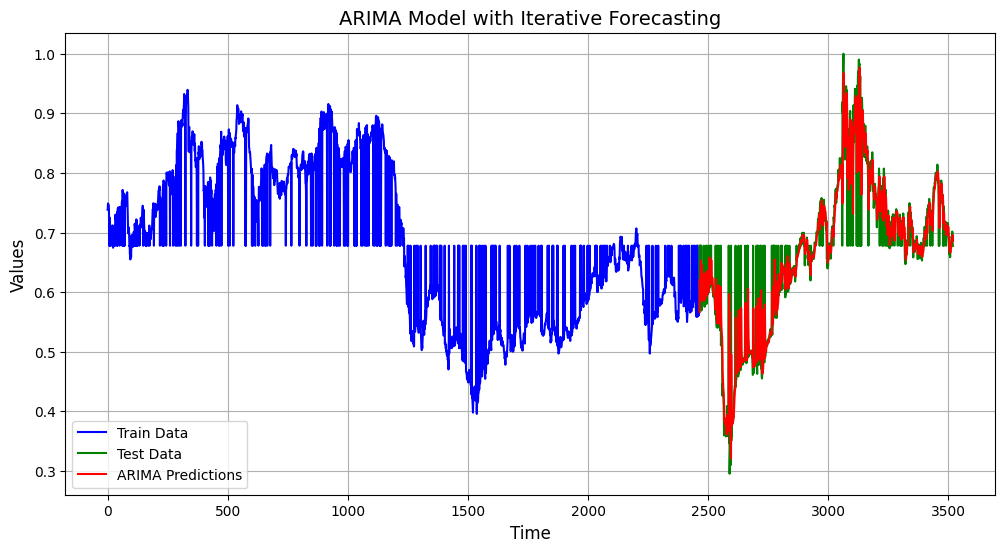

In [17]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(range(len(train_data)), train_data, label="Train Data", color="blue")
plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data, label="Test Data", color="green")
plt.plot(range(len(train_data), len(train_data) + len(test_data)), predictions, label="ARIMA Predictions", color="red")
plt.title("ARIMA Model with Iterative Forecasting", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Values", fontsize=12)
plt.legend()
plt.grid()
plt.show()


In [22]:
# محاسبه MSE
mse = mean_squared_error(test_data, predictions)

# محاسبه R-Squared
r2 = r2_score(test_data, predictions)

# محاسبه MAE
mae = np.mean(np.abs(test_data - predictions))

# محاسبه RMSE
rmse = np.sqrt(mse)

# محاسبه MAPE
# Prevent division by zero by replacing 0 with a small value
y_test_safe = np.where(test_data == 0, 1e-10, test_data)

# Calculate MAPE
mape = np.mean(np.abs((test_data - predictions) / y_test_safe)) * 100

# mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

metrics_results={}
metrics_results["ARIMA"] = {
    'MSE': mse,
    'R-Squared': r2,
    'MAE': mae,
    'RMSE': rmse,
    'MAPE': mape
}

# نمایش نتایج
for model_type, metrics in metrics_results.items():
    print(f"\n{model_type} Performance:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")


ARIMA Performance:
MSE: 0.0025
R-Squared: 0.8466
MAE: 0.1391
RMSE: 0.0499
MAPE: 22.7302


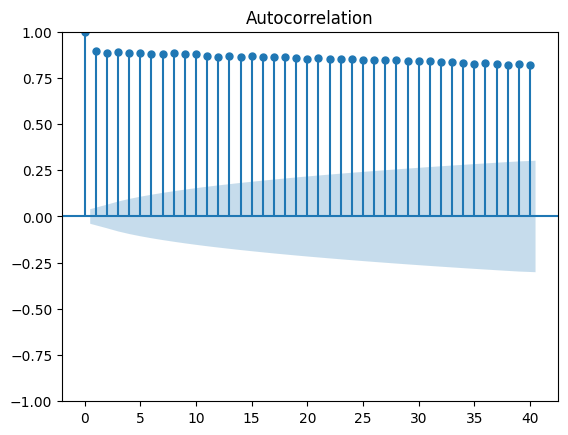

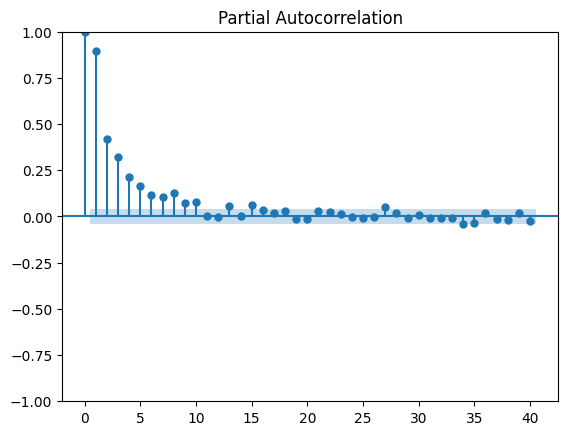

NameError: name 'optimal_arima_model' is not defined

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


series = train_data
plot_acf(series, lags=40)
plot_pacf(series, lags=40)
plt.show()
